In [1]:
#!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

In [2]:
#!wget https://universe.roboflow.com/ds/J2gwc4lbUt?key=EDrj9yWOXp -O indoor_object_detection.zip

In [3]:
#!unzip "indoor_object_detection.zip" -d "dataset2/"

## Setup

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

from datetime import datetime

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization


2024-02-05 00:13:36.220358: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 00:13:36.398257: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 00:13:36.398297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 00:13:36.426394: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 00:13:36.486307: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend


## Hyperparameters

In [5]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 100
GLOBAL_CLIPNORM = 10.0

In [6]:
class_ids = [
    #"TV", "bed", "chair", "clock", "console", "consoleeeeee", "door", "fan", "light", "sofa", "switchboard", "table"
    "emptychair", "fullchair"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "../dataset2/train/"
path_annot = "../dataset2/train/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [7]:

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/4780 [00:00<?, ?it/s]

In [8]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

2024-02-05 00:16:02.850688: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 00:16:02.944460: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 00:16:02.944495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 00:16:02.947688: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 00:16:02.947728: I external/local_xla/xla/stream_executor

In [9]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [10]:
print(len(image_paths))
print(num_val)
print(train_data.__len__())

4780
956
tf.Tensor(3824, shape=(), dtype=int64)


In [11]:

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


In [12]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

## Creating Training Dataset

In [13]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation Dataset

In [14]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

In [16]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_xs_backbone_coco",  # We will use yolov8 small backbone with coco weights
    #trainable = False
)

/home/andrea/.local/lib/python3.10/site-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/andrea/.local/lib/python3.10/site-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [17]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    #fpn_depth=1
)
#yolo.summary()

In [18]:
#for layer in yolo.layers:
#    if "yolo_v8_head" in layer.name:
#        #print(layer.name + " - " + str(layer.trainable))
#        layer.trainable = True
#    else:
#        layer.trainable = False
#        
#yolo.summary()

In [19]:
yolo.load_weights("model-xs--test2-02042024-192805.h5")
#yolo = keras_cv.models.load("model.h5")

## Compile the Model

In [20]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)
#yolo.summary()

In [21]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        #self.best_map = -1.0
        self.best_map = 999

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        #for batch in self.data:
        #    images, y_true = batch[0], batch[1]
        #    y_pred = self.model.predict(images, verbose=0)
        #    self.metrics.update_state(y_true, y_pred)

        #metrics = self.metrics.result(force=False)
        #logs.update(metrics)

        #print(metrics)
        #current_map = metrics["MaP"]
        current_map = logs["val_loss"]
        if current_map < self.best_map:
            self.best_map = current_map
            now = datetime.now()
            self.model.save(self.save_path + "-test2.h5")

        return logs


In [22]:
#yolo.save("model_3ep.h5")

## Train the Model

In [ ]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model-xs")],
)

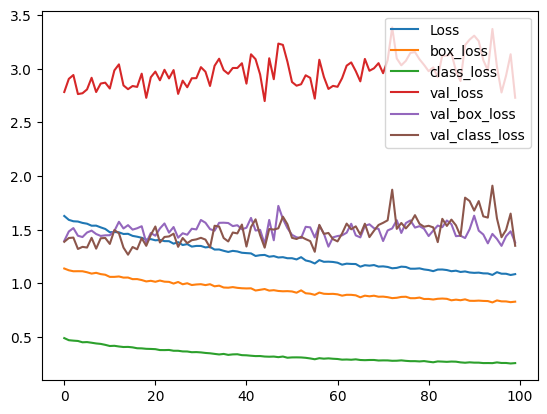

In [24]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['box_loss'], label='box_loss')
plt.plot(history.history['class_loss'], label='class_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_box_loss'], label='val_box_loss')
plt.plot(history.history['val_class_loss'], label='val_class_loss')
plt.legend(loc="upper right")
plt.show()

In [25]:
pd.DataFrame.from_dict(history.history).to_csv('model-xs-test2-ep51-history.csv',index=False)

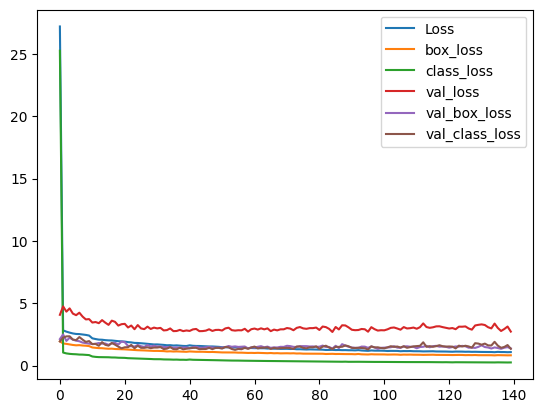

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("model-s-test2-history-global.csv")

plt.plot(df['loss'], label='Loss')
plt.plot(df['box_loss'], label='box_loss')
plt.plot(df['class_loss'], label='class_loss')
plt.plot(df['val_loss'], label='val_loss')
plt.plot(df['val_box_loss'], label='val_box_loss')
plt.plot(df['val_class_loss'], label='val_class_loss')
plt.legend(loc="upper right")
plt.show()